In [1]:
from augur.utils import json_to_tree
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
import numpy as np
import pandas as pd
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Seq import MutableSeq
from collections import Counter
import requests
import random
import math
import json
from scipy import stats

Make an expectation for wait times by randomly putting mutations on tree and then calculating wait times

In [255]:
tree_url = 'https://nextstrain-blab.s3.amazonaws.com/ncov_adaptive-evolution_2021-05-15.json'

tree_json = requests.get(tree_url).json()

#Put tree in Bio.Phylo format
tree = json_to_tree(tree_json)

Find the actual number of S1 and RdRp mutations

In [207]:
#Function to find path from root to clade
def get_parent(tree, child_clade):
    node_path = tree.get_path(child_clade)
    return node_path

In [208]:
def consolidate_deletions(mutation_list):
    """
    For deletion mutations, consider adjacent sites as part of the same deletion
    """
    
    without_deletions = [x for x in mutation_list if x[-1]!='-' and x[0]!='-']
    #consolidate deletions and reversions
    deletions_only = [x for x in mutation_list if x[-1]=='-' or x[0]=='-']
    deletions_only.sort(key=lambda x:x[1:-1])
    
    
    #keep track of start of separate deletions
    separate_deletions = []

    # if there are deletions, count a run of consecutive sites as a single deletion/mutation
    if len(deletions_only) != 0:
        separate_deletions.append(deletions_only[0])

        deletion_tracker = int(deletions_only[0][1:-1])
        
        for deletion in deletions_only[1:]:

            deleted_pos = int(deletion[1:-1])
            if deleted_pos == deletion_tracker+1:
                pass
            else:
                separate_deletions.append(deletion)
            deletion_tracker = deleted_pos
    
    consolidated_mutation_list = separate_deletions + without_deletions
            
    return consolidated_mutation_list

In [209]:
# make dictionary with gene name as key and reference sequence of that gene as value
reference_sequence_aa = {}
reference_sequence_nt = {}


# make dictionary giving gene by genomic location 
reference_gene_locations = {}

# make dictionary saying what codon within the gene a certain genomic location falls within
# and whether the mutation is at pos 0, 1 or 2 within codon
reference_gene_codon = {}

for record in SeqIO.parse(open("reference_seq_edited.gb","r"), "genbank"):
    genome_seq = record.seq
    for feature in record.features:
        if feature.type == 'CDS':
            # allow RdRp to overwrite Orf1a and Orf1b, 
            # to take care of changed reading frame due to  ribosome slippage
            # S1 and S2 will also overwrite spike
            for pos in range(int(feature.location.start), int(feature.location.end)):
                reference_gene_locations[pos] = feature.qualifiers['gene'][0]
                codon_num = math.floor((pos-feature.location.start)/3)
                pos_in_codon = ((pos-feature.location.start)-codon_num*3)
                reference_gene_codon[pos] = (codon_num, pos_in_codon)
                
            gene_seq = feature.location.extract(record.seq)
            reference_sequence_nt[feature.qualifiers['gene'][0]] = gene_seq
            gene_seq_aa = gene_seq.translate()
            reference_sequence_aa[feature.qualifiers['gene'][0]] = gene_seq_aa

/Users/katekistler/anaconda3/envs/ncov/lib/python3.6/site-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


In [210]:
# make dictionary with length of each gene
gene_lengths_aa = {k:len(v) for k,v in reference_sequence_aa.items()}
gene_lengths_aa['Nsp6'] = 290
gene_lengths_aa['Nsp4'] = 485

In [211]:
# dictionary of list of colors for emerging lineages, depending on total number of lineages
color_palettes = {8: ['#4068CF','#5098B9','#6CB28C','#94BD62','#BFBB47','#DFA53B','#E67131','#DB2823'], 
                  9: ['#3E5DD0','#4A8CC2','#60AA9E','#80B974','#A6BE55','#CBB742','#E29D39','#E56A2F','#DB2823'], 
                  10: ['#3F52CD','#4681CA','#57A1AD','#70B487','#90BC65','#B4BD4C','#D3B240','#E59638','#E4642E','#DB2823'], 
                  11: ['#3F47C9','#4274CE','#4F97BB','#64AC99','#7EB976','#9EBE5A','#BEBB48','#D9AE3E','#E69036','#E35F2D','#DB2823'], 
                  12: ['#403CC5','#4067CF','#4A8BC3','#5AA4A9','#6FB488','#8BBB69','#A9BD53','#C7B944','#DDA93C','#E68A35','#E35C2C','#DB2823'], 
                  13: ['#4433BE','#3E5ACF','#457FCB','#529AB6','#64AD98','#7BB77A','#96BD60','#B3BD4D','#CDB642','#DFA43B','#E68434','#E2582C','#DB2823'], 
                  14: ['#492AB5','#3F4CCB','#4271CE,''#4C8FC0','#5AA5A8','#6DB38A','#85BA6F','#A0BE59','#BBBC49','#D2B340','#E19F3A','#E68033','#E2562B','#DB2823'], 
                  15: ['#4D21AD','#403FC6','#3F63CF','#4783C8','#539BB5','#63AC9B','#77B67F','#8EBC66','#A8BD53','#C1BA47','#D6B03F','#E39C39','#E67C33','#E1532B','#DB2823'], 
                  16: ['#571EA2','#4334BF','#3F55CE','#4376CD','#4C91C0','#59A4A9','#6AB18F','#7FB975','#97BD5F','#AFBD4F','#C7B944','#D9AD3D','#E49838','#E67932','#E1512A','#DB2823'], 
                  17: ['#5E1D9D','#462EB9','#3F4CCB','#416CCE','#4887C6','#539CB3','#62AB9C','#74B582','#89BB6B','#A0BE59','#B7BD4B','#CCB742','#DDAA3C','#E69537','#E67631','#E14F2A','#DB2823']}
                      

In [212]:
def nuc_changes_from_reference(muts_on_path):
    """
    From all the of the nucleotide changes that have occurred on the path from root to branch, 
    find the most recent nuc mutation at each site (giving the genotype at the branch)
    """
    
    final_muts_from_ref = {}

    # overwrites genotypes at pos in historical order
    for x in muts_on_path:
        x_pos = int(x[1:-1])
        final_muts_from_ref[x_pos] = x[-1]
        

    return final_muts_from_ref

In [213]:
def determine_synonymous(nuc_muts_on_branch, parent_diffs_from_ref):
    
    parent_diffs_pos = [int(k) for k,v in parent_diffs_from_ref.items()]

    
    # make dictionary of synonymous (and noncoding) mutations to add to tree
    syn_muts = {}
    
    # don't care about deletions because they are obviously not synonymous
    for mut in nuc_muts_on_branch:
        if mut[-1]!= '-' and mut[0]!='-':
            mut_pos = int(mut[1:-1])
            # find what gene this mut happens in
            if (mut_pos-1) in reference_gene_locations.keys():
                mut_gene = reference_gene_locations[mut_pos-1]
                mut_codon_num = reference_gene_codon[mut_pos-1][0]
                mut_codon_pos = reference_gene_codon[mut_pos-1][1]
                
                # find the reference sequence of the codon this mutation occurs in
                codon_ref_aa = reference_sequence_aa[mut_gene][mut_codon_num]
                
                codon_ref_nt = reference_sequence_nt[mut_gene][(mut_codon_num*3):(mut_codon_num*3+3)]
                
                # check if a mutation occurred within the same codon in a parent
                # and if so, change the reference codon sequence accordingly, 
                # to tell whether the mutation at this branch is synonymous or not
                codon_genome_pos = list(range((mut_pos-1-mut_codon_pos),(mut_pos-1-mut_codon_pos+3)))
                
                parent_codon = codon_ref_nt
                for parent_diff in parent_diffs_pos:
                    parent_diff_zero_based = parent_diff-1
                    if parent_diff_zero_based in codon_genome_pos:
                        parent_diff_pos = codon_genome_pos.index(parent_diff_zero_based)
                        parent_codon = MutableSeq(str(codon_ref_nt))
                        parent_codon[parent_diff_pos] = parent_diffs_from_ref[parent_diff]
                        parent_codon = parent_codon.toseq()
                
                
                codon_mutated = MutableSeq(str(parent_codon))
                #if deletion (or seq error) has happened at neighboring nucleotide
                if '-' in codon_mutated:
                    pass
                else:
                    codon_mutated[mut_codon_pos] = mut[-1]
                    codon_mutated = codon_mutated.toseq()
                    codon_mutated_translation = codon_mutated.translate()

                    if str(codon_ref_aa) == str(codon_mutated_translation):
                        if mut_gene in syn_muts.keys():
                            syn_muts[mut_gene] += [mut]
                        else:
                            syn_muts[mut_gene] = [mut]
                        
                

            else:
                if 'noncoding' in syn_muts.keys():
                    syn_muts['noncoding'] += [mut]
                else:
                    syn_muts['noncoding'] = [mut]
                    
    return syn_muts

In [214]:
def add_syn_mut_attribute(tree):
    
    for node in tree.find_clades():

        node.node_attrs['syn_muts'] = {}

        # only care if this branch has some nucleotide mutations
        if hasattr(node, 'branch_attrs'):
            if 'nuc' in node.branch_attrs['mutations']:

                nuc_muts_on_branch = node.branch_attrs['mutations']['nuc']

                node_path = get_parent(tree, node)

                nucleotide_mut_path = []

                # find all nucleotide mutations that happened in parents, 
                # in case they affect codons mutated on this branch
                for parent in node_path[-1]:
                    if hasattr(parent, 'branch_attrs'):
                        if 'nuc' in parent.branch_attrs['mutations']:
                            nucleotide_mut_path+=parent.branch_attrs['mutations']['nuc']

                parent_diffs_from_ref = nuc_changes_from_reference(nucleotide_mut_path)

                syn_muts_dict = determine_synonymous(nuc_muts_on_branch, parent_diffs_from_ref)

                node.node_attrs['syn_muts'] = syn_muts_dict


In [256]:
add_syn_mut_attribute(tree)

In [262]:
for node in tree.find_clades(terminal=False):

    node.s1_nonsyn_at_node = 0
    node.s1_syn_at_node = 0
    node.rdrp_nonsyn_at_node = 0
    node.s2_syn_at_node = 0
    node.nsp6_nonsyn_at_node = 0
    node.nsp4_nonsyn_at_node = 0
    node.n_nonsyn_at_node = 0
    node.e_nonsyn_at_node = 0
    node.m_nonsyn_at_node = 0

    if hasattr(node, "node_attrs") and 'S1' in node.node_attrs['syn_muts']:
        node.s1_syn_at_node = len(node.node_attrs['syn_muts']['S1'])


    if hasattr(node, 'branch_attrs'):

        s1_nonsyn_at_this_node = []
        s2_nonsyn_at_this_node = []
        if "S" in node.branch_attrs["mutations"]:
            for mut in node.branch_attrs["mutations"]["S"]:
                if int(mut[1:-1]) in range(14,686):
                    s1_nonsyn_at_this_node.append(mut)
                elif int(mut[1:-1]) in range(687,1274):
                    s2_nonsyn_at_this_node.append(mut)

        s1_consolidated = consolidate_deletions(s1_nonsyn_at_this_node)
        node.s1_nonsyn_at_node = len(s1_consolidated)
        s2_consolidated = consolidate_deletions(s2_nonsyn_at_this_node)
        node.s2_nonsyn_at_node = len(s2_consolidated)



        rdrp_nonsyn_at_this_node = []
        nsp6_nonsyn_at_this_node = []
        nsp4_nonsyn_at_this_node = []
        if "ORF1a" in node.branch_attrs["mutations"]:
            for mut in node.branch_attrs["mutations"]["ORF1a"]:
                if int(mut[1:-1]) in range(4492,4401):
                    rdrp_nonsyn_at_this_node.append(mut)
                elif int(mut[1:-1]) in range(3570,3859):
                    # exclude this ancestral mut
                    if mut!= 'K3833N':
                        nsp6_nonsyn_at_this_node.append(mut)
                elif int(mut[1:-1]) in range(2777,3261):
                    nsp4_nonsyn_at_this_node.append(mut)


        if "ORF1b" in node.branch_attrs["mutations"]:
            for mut in node.branch_attrs["mutations"]["ORF1b"]:
                if int(mut[1:-1]) in range(1,923):
                    rdrp_nonsyn_at_this_node.append(mut)

        rdrp_consolidated = consolidate_deletions(rdrp_nonsyn_at_this_node)
        node.rdrp_nonsyn_at_node = len(rdrp_consolidated)
        nsp6_consolidated = consolidate_deletions(nsp6_nonsyn_at_this_node)
        node.nsp6_nonsyn_at_node = len(nsp6_consolidated)
        nsp4_consolidated = consolidate_deletions(nsp4_nonsyn_at_this_node)
        node.nsp4_nonsyn_at_node = len(nsp4_consolidated)
        
        n_nonsyn_at_this_node = []
        if "N" in node.branch_attrs["mutations"]:
            for mut in node.branch_attrs["mutations"]["N"]:
                n_nonsyn_at_this_node.append(mut)

        n_consolidated = consolidate_deletions(n_nonsyn_at_this_node)
        node.n_nonsyn_at_node = len(n_consolidated)

        e_nonsyn_at_this_node = []
        if "E" in node.branch_attrs["mutations"]:
            for mut in node.branch_attrs["mutations"]["E"]:
                e_nonsyn_at_this_node.append(mut)
            
        e_consolidated = consolidate_deletions(e_nonsyn_at_this_node)
        node.e_nonsyn_at_node = len(e_consolidated)
        
        m_nonsyn_at_this_node = []
        if "M" in node.branch_attrs["mutations"]:
            for mut in node.branch_attrs["mutations"]["M"]:
                m_nonsyn_at_this_node.append(mut)
            
        m_consolidated = consolidate_deletions(m_nonsyn_at_this_node)
        node.m_nonsyn_at_node = len(m_consolidated)
    


In [265]:
# find number of nodes that have S1 mutations
# consider only internal branches
nodes_with_s1_nonsyn = 0
total_s1_nonsyn = 0
nodes_with_s1_syn = 0
total_s1_syn = 0

for node in tree.find_clades(terminal=False):
    # look only at nodes with at least 5 descendents, to exclude weird stuff at tips and sequencing errors
    if len(node.get_terminals()) >=3:
        if node.s1_nonsyn_at_node!= 0:
            nodes_with_s1_nonsyn+=1
            total_s1_nonsyn += node.s1_nonsyn_at_node
        if node.s1_syn_at_node!=0:
            nodes_with_s1_syn+=1
            total_s1_syn += node.s1_syn_at_node
        
        
print(f'Nodes with S1 nonsyn mutations: {nodes_with_s1_nonsyn}')
print(f'Total number of S1 nonsyn mutations: {total_s1_nonsyn}')
print(f'Nodes with S1 syn mutations: {nodes_with_s1_syn}')
print(f'Total number of S1 syn mutations: {total_s1_syn}')


# find number of nodes that have RdRp mutations
nodes_with_rdrp_muts = 0
total_rdrp_muts = 0

for node in tree.find_clades(terminal=False):
    # look only at nodes with at least 3 descendents, to exclude sequencing errors
    if len(node.get_terminals()) >=3:
        if node.rdrp_nonsyn_at_node!= 0:
            nodes_with_rdrp_muts+=1
            total_rdrp_muts += node.rdrp_nonsyn_at_node
        
print(f'Nodes with RdRp mutations: {nodes_with_rdrp_muts}')
print(f'Total number of RdRp mutations: {total_rdrp_muts}')

first_timepoint = tree.root.node_attrs['num_date']['value']
last_timepoint = 0
for node in tree.find_clades(terminal=False):
    if node.node_attrs['num_date']['value'] > last_timepoint:
        last_timepoint = node.node_attrs['num_date']['value']
        
print(f'Time window: {first_timepoint}-{last_timepoint}')
    

Nodes with S1 nonsyn mutations: 277
Total number of S1 nonsyn mutations: 353
Nodes with S1 syn mutations: 100
Total number of S1 syn mutations: 104
Nodes with RdRp mutations: 98
Total number of RdRp mutations: 101
Time window: 2019.982929101653-2021.3404645014461


In [263]:
total_s2_nonsyn = 0
total_nsp6_nonsyn = 0
total_nsp4_nonsyn = 0
total_e_nonsyn = 0
total_n_nonsyn = 0
total_m_nonsyn = 0

for node in tree.find_clades(terminal=False):
    # look only at nodes with at least 3 descendents, to exclude sequencing errors
    if len(node.get_terminals()) >=3:
        if node.s2_nonsyn_at_node!= 0:
            total_s2_nonsyn += node.s2_nonsyn_at_node
        if node.nsp6_nonsyn_at_node!= 0:
            total_nsp6_nonsyn += node.nsp6_nonsyn_at_node
        if node.nsp4_nonsyn_at_node!= 0:
            total_nsp4_nonsyn += node.nsp4_nonsyn_at_node
        if node.e_nonsyn_at_node!= 0:
            total_e_nonsyn += node.e_nonsyn_at_node        
        if node.m_nonsyn_at_node!= 0:
            total_m_nonsyn += node.m_nonsyn_at_node
        if node.n_nonsyn_at_node!= 0:
            total_n_nonsyn += node.n_nonsyn_at_node

In [264]:
print(total_s2_nonsyn, total_nsp6_nonsyn, 
      total_nsp4_nonsyn, total_e_nonsyn, 
      total_m_nonsyn, total_n_nonsyn)

134 119 100 12 32 280


In [260]:
total_branchs = 0
for node in tree.find_clades(terminal=False):
    if len(node.get_terminals()) >=3:
        total_branchs+=1

In [261]:
# find all branch lengths
root_date = tree.root.node_attrs['num_date']['value']

# keep track of parts of paths that have already been considered
paths_segments_already_used_all = []

# store all wait times between branchs
branch_lengths_all = []
branch_names_all = []

for node in tree.find_clades(terminal=False):
    
    if len(node.get_terminals()) >=3:


        node_path = get_parent(tree, node)

        # find the branch length (in decimal years) between node and previous node
        path_dates = [n.node_attrs['num_date']['value'] for n in node_path]

        if len(path_dates) > 1:
            path_dates_with_root = [root_date] + path_dates
            branch_lengths = [j-i for i, j in zip(path_dates_with_root[:-1], path_dates_with_root[1:])]

    #         branch_lengths = [j-i for i, j in zip(path_dates[:-1], path_dates[1:])]


            for n_index in range(len(node_path)):

                # name of the node at the end of the branch
                # branch length will be assigned to this node because 
                # it is the length of the branch leading to this node
                branch_name = node_path[n_index].name
                if n_index==0:
                    preceding_node_name = tree.root.name
                else:
                    preceding_node_name = node_path[n_index-1].name


                if [preceding_node_name, branch_name] not in paths_segments_already_used_all:

                    branch_length = branch_lengths[n_index]

                    if branch_length<0:
                        branch_length = 0.0

                    branch_lengths_all.append(branch_length)
                    branch_names_all.append(branch_name)
    #                 branch_names_all.append([root_name, branch_name])
                    paths_segments_already_used_all.append([preceding_node_name, branch_name])

            


Throw each of the S1 mutations onto a random branch of the tree by picking a random branch X times (where X= total number of S1 mutations). Can result in multiple hits on same branch (as with empirical data)

In [68]:
def randomize_mutations_on_tree_multinomial(tree, num_mutations, branch_lengths, branch_names):
    
    # multinomial draw to randomize mutations on tree
    branch_lengths_normalized = [x/sum(branch_lengths) for x in branch_lengths]

    num_branches = len(branch_lengths_normalized)

    hits = list(np.random.multinomial(num_mutations, branch_lengths_normalized, size=1))[0]
    
    muts_on_branch = dict(zip(branch_names, hits))

    for node in tree.find_clades(terminal=False):
        if len(node.get_terminals()) >=3:
        # no branch length at root
            if node.name == 'NODE_0000000':
                node.random_muts = 0

            else:
                node.random_muts = muts_on_branch[node.name] 
    return tree
        

In [15]:
def convert_linege_names(old_name):
    
#     old_to_new = {'A.23.1': 'A.23.1', 'B.1.1.7': 'B.1.1.7 (Alpha)', 'B.1.351': 'B.1.351 (Beta)', 
#                   'B.1.427+B.1.429': 'B.1.427/429 (Epsilon)', 'B.1.525': 'B.1.525 (Eta)', 'B.1.526': 'B.1.526 (Iota)', 
#                   'B.1.617': 'B.1.617.1/2 (Delta/Kappa)', 
#                   'C.37': 'C.37 (Lambda)', 'P.1': 'P.1 (Gamma)', 'P.3': 'P.3', 
#                   'unassigned': 'basal'}
    
    old_to_new = {'unassigned': 'basal'}
    if old_name in old_to_new.keys():
        new_name = old_to_new[old_name]
    else:
        new_name = old_name
    
    return new_name

In [77]:
def get_linear_reg_stats(mut_location, nonsyn_syn, x_axis):
    
    df_subset = muts_information_df.copy()
    df_subset = df_subset[(df_subset['mut_location']==mut_location)&(df_subset['nonsyn_syn']==nonsyn_syn)]
    
    if x_axis == 'logistic_growth':
        df_subset = df_subset.dropna()
    
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_subset[x_axis], df_subset['muts_per_codon'])
    slope = round(slope, 4)
    r_value = round(r_value, 2)
    
    return slope, r_value

In [270]:
def run_growth_randomizations(iterations, save_filename):

#     genes = ['S1','RdRp']
    genes = ['S2', 'Nsp6', 'Nsp4', 'E', 'M', 'N']

    growth_stats_dict = {'growth_rate_stats':[]}

    for gene in genes:
        if gene == 'S1':
            nonsyn_syn_options=['nonsyn', 'syn']
        else:
            nonsyn_syn_options=['nonsyn']

        for nonsyn_syn in nonsyn_syn_options:

            for x in range(iterations):
                #Download tree json
                tree_json = requests.get(tree_url).json()

                #Put tree in Bio.Phylo format
                tree = json_to_tree(tree_json)
                
                # randomize mutation positions on tree
                if gene == 'RdRp':
                    tree = randomize_mutations_on_tree_multinomial(tree, total_rdrp_muts, branch_lengths_all, branch_names_all)

                elif gene == 'S1':
                    if nonsyn_syn == 'nonsyn':
                        tree = randomize_mutations_on_tree_multinomial(tree, total_s1_nonsyn, branch_lengths_all, branch_names_all)
                    elif nonsyn_syn == 'syn':
                        tree = randomize_mutations_on_tree_multinomial(tree, total_s1_syn, branch_lengths_all, branch_names_all)
                
                elif gene == 'S2':
                    tree = randomize_mutations_on_tree_multinomial(tree, total_s2_nonsyn, branch_lengths_all, branch_names_all) 
                elif gene == 'Nsp6':
                    tree = randomize_mutations_on_tree_multinomial(tree, total_nsp6_nonsyn, branch_lengths_all, branch_names_all)
                elif gene == 'Nsp4':
                    tree = randomize_mutations_on_tree_multinomial(tree, total_nsp4_nonsyn, branch_lengths_all, branch_names_all)
                elif gene == 'E':
                    tree = randomize_mutations_on_tree_multinomial(tree, total_e_nonsyn, branch_lengths_all, branch_names_all)
                elif gene == 'M':
                    tree = randomize_mutations_on_tree_multinomial(tree, total_m_nonsyn, branch_lengths_all, branch_names_all)
                elif gene == 'N':
                    tree = randomize_mutations_on_tree_multinomial(tree, total_n_nonsyn, branch_lengths_all, branch_names_all)
                
                # keep track of logistic growth rate for this iteration
                muts_information = []
                # count accumulation of mutations on path
                for node in tree.find_clades(terminal=False):
                    
                    # only care if it has a logistic growth rate
                    if "logistic_growth" in node.node_attrs:
                        logistic_growth = node.node_attrs["logistic_growth"]["value"]

                        #Find all parents of the node
                        parents = get_parent(tree, node)

                        #Find mutations that occur in the parents, and at node
                        parents_random_muts = 0

                        for parent in parents:
                            if hasattr(parent, "random_muts"):
                                parents_random_muts+=parent.random_muts
                                
                        muts_information.append({'muts_per_codon': parents_random_muts/gene_lengths_aa[gene],
                                                 'logistic_growth': logistic_growth})
                        
    
                

                muts_information_df = pd.DataFrame(muts_information)
                slope, intercept, r_value, p_value, std_err = stats.linregress(muts_information_df['logistic_growth'], 
                                                                               muts_information_df['muts_per_codon'])

                growth_stats_dict['growth_rate_stats'].append({'data': 'randomized', 'iteration':x,
                                                               'gene': gene, 'nonsyn_syn': nonsyn_syn, 
                                                               'r_value':r_value})

    with open(save_filename, 'w') as outfile:
        json.dump(growth_stats_dict, outfile)

In [436]:
run_growth_randomizations(200, 'growth_rate_stats/growth_stats-supp_200itsmore.json')

In [434]:
def plot_fig1c(data_files, filename=None):

    # dataframe for all wait time information, 
    # each row is an iteration for expected s1 or rdrp, syn or nonsyn
    to_plot = pd.DataFrame(columns = ['data', 'iteration', 'gene', 'nonsyn_syn', 'r_value'])
    
    for data_file in data_files:
        with open(data_file) as json_file:
            data = json.load(json_file)
            df = pd.DataFrame(data['growth_rate_stats'])
            to_plot = pd.concat([to_plot, df])
            
    num_iterations = len(to_plot)/3
    
    with open('growth_rate_stats/growth_stats_observed.json') as observed_json:
        data_observed = json.load(observed_json)
        to_plot_observed = pd.DataFrame(data_observed['growth_rate_stats'])

    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(14,1.25), sharey=True)
#     sns.set_style("white")

    s1_expected = to_plot[(to_plot['gene']=='S1')&(to_plot['nonsyn_syn']=='nonsyn')]
    ax1 = sns.histplot(data=s1_expected, 
                       x='r_value', color = "#ABABAB",
                      element = 'step',alpha=0.25,
                      bins=10, stat='count', ax=ax1)
    s1_observed_r = to_plot_observed[(to_plot_observed['gene']=='S1'
                                     )&(to_plot_observed['nonsyn_syn']=='nonsyn')]['r_value'].values[0]

    ax1.axvline(x=s1_observed_r, color = "#4770eb", linewidth=4)
    s1_pvalue= len(s1_expected[s1_expected['r_value']>s1_observed_r])/num_iterations
    if s1_pvalue < 0.005:
        s1_pvalue = '< 0.005'
        ax1.annotate(f'p-value: {s1_pvalue}', xy=((s1_observed_r), 0.65), 
                     xycoords='axes fraction',ha='left', size=11, fontweight='bold')
    else:
        ax1.annotate(f'p-value: {round(s1_pvalue, 2)}', xy=((s1_observed_r), 0.65), 
                     xycoords='axes fraction',ha='left', size=11, fontweight='bold')
    
    
    s1_syn_expected = to_plot[(to_plot['gene']=='S1')&(to_plot['nonsyn_syn']=='syn')]
    ax2 = sns.histplot(data=s1_syn_expected, 
                       x='r_value', color = "#ABABAB",
                      element = 'step',alpha=0.25,
                      bins=10, stat='count', ax=ax2)
    s1_syn_observed_r = to_plot_observed[(to_plot_observed['gene']=='S1'
                                   )&(to_plot_observed['nonsyn_syn']=='syn')]['r_value'].values[0]
    ax2.axvline(x=s1_syn_observed_r, color = "#5094e3", linewidth=4)
    s1_syn_pvalue= len(s1_syn_expected[s1_syn_expected['r_value']>s1_syn_observed_r])/num_iterations
    ax2.annotate(f'p-value: {round(s1_syn_pvalue, 2)}', xy=((s1_syn_observed_r+0.5), 0.65), 
                 xycoords='axes fraction', ha='left', size=11, fontweight='bold')

    
    rdrp_expected = to_plot[(to_plot['gene']=='RdRp')&(to_plot['nonsyn_syn']=='nonsyn')]
    ax3 = sns.histplot(data=rdrp_expected, 
                       x='r_value', color = "#ABABAB",
                      element = 'step',alpha=0.25,
                      bins=10, stat='count', ax=ax3)
    rdrp_observed_r = to_plot_observed[(to_plot_observed['gene']=='RdRp'
                                   )&(to_plot_observed['nonsyn_syn']=='nonsyn')]['r_value'].values[0]
    ax3.axvline(x=rdrp_observed_r, color = "#ff8c3a", linewidth=4)
    
    rdrp_pvalue= len(rdrp_expected[rdrp_expected['r_value']>rdrp_observed_r])/num_iterations
    ax3.annotate(f'p-value: {round(rdrp_pvalue, 2)}', xy=((rdrp_observed_r+0.15), 0.65), 
                 xycoords='axes fraction',ha='left', size=11, fontweight='bold')




    ax1.set_title(f'S1 nonsynonymous', fontsize = 13, fontweight='bold')
    ax2.set_title(f'S1 synonymous', fontsize = 13, fontweight='bold')
    ax3.set_title(f'RdRp nonsynonymous', fontsize = 13, fontweight='bold')
    
    ax1.set_xlabel('$R^2$', fontsize=12)
    ax2.set_xlabel('$R^2$', fontsize=12)
    ax3.set_xlabel('$R^2$', fontsize=12)
    
    for ax in [ax1, ax2, ax3]:
        ax.set_ylabel('')
        plt.setp(ax.get_yticklabels(), visible=False)
        ax.tick_params(axis='x', which='major', labelsize=10)
    
    
    sns.despine(left=False, bottom=False)
    plt.subplots_adjust(wspace=0.1)
    
    plt.figtext(0.04, 0.94, 'C', fontsize=20, fontweight='bold')

    if filename:
        fig.savefig(filename, dpi=300, bbox_inches='tight')
    
    

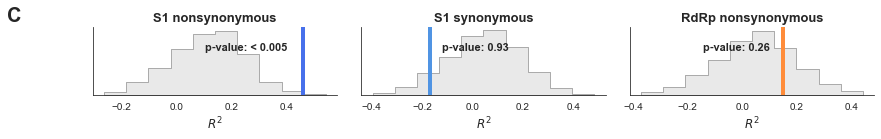

In [435]:
plot_fig1c(['growth_rate_stats/growth_stats_50it.json', 
            'growth_rate_stats/growth_stats_50itmore.json', 
            'growth_rate_stats/growth_stats_200its.json', 
            'growth_rate_stats/growth_stats_400its.json', 
            'growth_rate_stats/growth_stats_300its.json'], filename='plots/fig1c_r_stats.png')

In [438]:
def plot_fig1_supp_b(data_files_main, data_files_supp, filename=None):

    # dataframe for all wait time information, 
    # each row is an iteration for expected 'S2', 'Nsp6', 'Nsp4', 'E', 'M', 'N'
    to_plot = pd.DataFrame(columns = ['data', 'iteration', 'gene', 'nonsyn_syn', 'r_value'])
    
    for data_file in data_files_supp:
        with open(data_file) as json_file:
            data = json.load(json_file)
            df = pd.DataFrame(data['growth_rate_stats'])
            to_plot = pd.concat([to_plot, df])

    
    for data_file in data_files_main:
        with open(data_file) as json_file:
            data = json.load(json_file)
            df = pd.DataFrame(data['growth_rate_stats'])
            to_plot = pd.concat([to_plot, df])
            
    num_iterations = len(to_plot)/6
    
    with open('growth_rate_stats/growth_stats_observed.json') as observed_json:
        data_observed = json.load(observed_json)
        to_plot_observed = pd.DataFrame(data_observed['growth_rate_stats'])

    
    fig, ((ax1, ax2), (ax3, ax4), ( ax5, ax6), (ax7, ax8)) = plt.subplots(4,2, figsize=(8.5,3), sharey=True, sharex=True)
    sns.set_style("white")

    
    s1_expected = to_plot[(to_plot['gene']=='S1')&(to_plot['nonsyn_syn']=='nonsyn')]
    ax1 = sns.histplot(data=s1_expected, 
                       x='r_value', color = "#ABABAB",
                      element = 'step',alpha=0.25,
                      bins=10, stat='count', ax=ax1)
    s1_observed_r = to_plot_observed[(to_plot_observed['gene']=='S1'
                                     )&(to_plot_observed['nonsyn_syn']=='nonsyn')]['r_value'].values[0]

    ax1.axvline(x=s1_observed_r, color = "#4770eb", linewidth=4)
    s1_pvalue= len(s1_expected[s1_expected['r_value']>s1_observed_r])/num_iterations
    if s1_pvalue < 0.005:
        s1_pvalue = '< 0.005'
        ax1.annotate(f'p-value: {s1_pvalue}', xy=((s1_observed_r), 0.65), 
                     xycoords='axes fraction', ha='left', size=11, fontweight='bold')
    
    
    
    s2_expected = to_plot[to_plot['gene']=='S2']
    ax2 = sns.histplot(data=s2_expected, 
                       x='r_value', color = "#ABABAB",
                      element = 'step',alpha=0.25,
                      bins=10, stat='count', ax=ax2)
    s2_observed_r = to_plot_observed[to_plot_observed['gene']=='S2']['r_value'].values[0]

    ax2.axvline(x=s2_observed_r, color = '#1238aa', linewidth=4)
    s2_pvalue= len(s2_expected[s2_expected['r_value']>s2_observed_r])/num_iterations
    ax2.annotate(f'p-value: {round(s2_pvalue, 2)}', xy=((s2_observed_r+0.1), 0.65), 
                 xycoords='axes fraction', ha='left', size=11, fontweight='bold')

    
    rdrp_expected = to_plot[(to_plot['gene']=='RdRp')&(to_plot['nonsyn_syn']=='nonsyn')]
    ax3 = sns.histplot(data=rdrp_expected, 
                       x='r_value', color = "#ABABAB",
                      element = 'step',alpha=0.25,
                      bins=10, stat='count', ax=ax3)
    rdrp_observed_r = to_plot_observed[(to_plot_observed['gene']=='RdRp'
                                   )&(to_plot_observed['nonsyn_syn']=='nonsyn')]['r_value'].values[0]
    ax3.axvline(x=rdrp_observed_r, color = "#ff8c3a", linewidth=4)
    
    rdrp_pvalue= len(rdrp_expected[rdrp_expected['r_value']>rdrp_observed_r])/num_iterations
    ax3.annotate(f'p-value: {round(rdrp_pvalue, 2)}', xy=((rdrp_observed_r+0.1), 0.65), 
                 xycoords='axes fraction', ha='left', size=11, fontweight='bold')
    
    
    
    n_expected = to_plot[to_plot['gene']=='N']
    ax4 = sns.histplot(data=n_expected, 
                       x='r_value', color = "#ABABAB",
                      element = 'step',alpha=0.25,
                      bins=10, stat='count', ax=ax4)
    n_observed_r = to_plot_observed[to_plot_observed['gene']=='N']['r_value'].values[0]
    ax4.axvline(x=n_observed_r, color = '#419D78', linewidth=4)
    n_pvalue= len(n_expected[n_expected['r_value']>n_observed_r])/num_iterations
    ax4.annotate(f'p-value: {round(n_pvalue, 2)}', xy=((n_observed_r+0.1), 0.65), 
                 xycoords='axes fraction', ha='left', size=11, fontweight='bold')

    
    e_expected = to_plot[to_plot['gene']=='E']
    ax5 = sns.histplot(data=e_expected, 
                       x='r_value', color = "#ABABAB",
                      element = 'step',alpha=0.25,
                      bins=10, stat='count', ax=ax5)
    e_observed_r = to_plot_observed[to_plot_observed['gene']=='E']['r_value'].values[0]
    ax5.axvline(x=e_observed_r, color = '#307358', linewidth=4)
    
    e_pvalue= len(e_expected[e_expected['r_value']>e_observed_r])/num_iterations
    ax5.annotate(f'p-value: {round(e_pvalue, 2)}', xy=((e_observed_r+0.12) , 0.65), 
                 xycoords='axes fraction', ha='left', size=11, fontweight='bold')

    m_expected = to_plot[to_plot['gene']=='M']
    ax6 = sns.histplot(data=m_expected, 
                       x='r_value', color = "#ABABAB",
                      element = 'step',alpha=0.25,
                      bins=10, stat='count', ax=ax6)
    m_observed_r = to_plot_observed[to_plot_observed['gene']=='M']['r_value'].values[0]
    ax6.axvline(x=m_observed_r, color = '#a2d9c3', linewidth=4)
    
    m_pvalue= len(m_expected[m_expected['r_value']>m_observed_r])/num_iterations
    ax6.annotate(f'p-value: {round(m_pvalue, 2)}', xy=((m_observed_r+0.1), 0.65), 
                 xycoords='axes fraction', ha='left', size=11, fontweight='bold')

    nsp6_expected = to_plot[to_plot['gene']=='Nsp6']
    ax7 = sns.histplot(data=nsp6_expected, 
                       x='r_value', color = "#ABABAB",
                      element = 'step',alpha=0.25,
                      bins=10, stat='count', ax=ax7)
    nsp6_observed_r = to_plot_observed[to_plot_observed['gene']=='Nsp6']['r_value'].values[0]
    ax7.axvline(x=nsp6_observed_r, color = "#c35100", linewidth=4)
    
    nsp6_pvalue= len(nsp6_expected[nsp6_expected['r_value']>nsp6_observed_r])/num_iterations
    ax7.annotate(f'p-value: {round(nsp6_pvalue, 2)}', xy=((nsp6_observed_r+0.1), 0.65), 
                 xycoords='axes fraction', ha='left', size=11, fontweight='bold')

    
    nsp4_expected = to_plot[to_plot['gene']=='Nsp4']
    ax8 = sns.histplot(data=nsp4_expected, 
                       x='r_value', color = "#ABABAB",
                      element = 'step',alpha=0.25,
                      bins=10, stat='count', ax=ax8)
    nsp4_observed_r = to_plot_observed[to_plot_observed['gene']=='Nsp4']['r_value'].values[0]
    ax8.axvline(x=nsp4_observed_r, color = "#ffc59c", linewidth=4)
    
    nsp4_pvalue= len(nsp4_expected[nsp4_expected['r_value']>nsp4_observed_r])/num_iterations
    ax8.annotate(f'p-value: {round(nsp4_pvalue, 2)}', xy=((nsp4_observed_r+0.1), 0.65), 
                 xycoords='axes fraction', ha='left', size=11, fontweight='bold')



#     ax1.set_title(f'S1 nonsynonymous', fontsize = 12, fontweight='bold')
#     ax2.set_title(f'S2 nonsynonymous', fontsize = 12, fontweight='bold')
#     ax3.set_title(f'RdRp nonsynonymous', fontsize = 12, fontweight='bold')
#     ax4.set_title(f'N nonsynonymous', fontsize = 12, fontweight='bold')
#     ax5.set_title(f'E nonsynonymous', fontsize = 12, fontweight='bold')
#     ax6.set_title(f'M nonsynonymous', fontsize = 12, fontweight='bold')
#     ax7.set_title(f'Nsp6 nonsynonymous', fontsize = 12, fontweight='bold')
#     ax8.set_title(f'Nsp4 nonsynonymous', fontsize = 12, fontweight='bold')
    

#     ax7.set_xlabel('$R^2$', fontsize=14)
#     ax8.set_xlabel('$R^2$', fontsize=14)
    
    for ax in [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]:
        ax.set_ylabel('')
        ax.set_xlabel('')
        plt.setp(ax.get_yticklabels(), visible=False)
        plt.setp(ax.get_xticklabels(), visible=False)
#         ax.tick_params(axis='x', which='major', labelsize=12)
    
    
    sns.despine(left=False, bottom=False)
    plt.subplots_adjust(wspace=0.2, hspace=0.5)
    

    if filename:
        fig.savefig(filename, dpi=300, bbox_inches='tight')
    
    

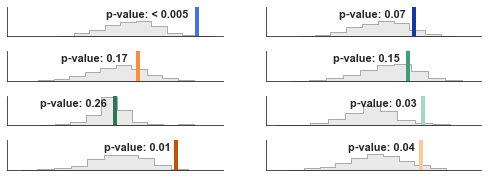

In [439]:
plot_fig1_supp_b(['growth_rate_stats/growth_stats_50it.json', 
            'growth_rate_stats/growth_stats_50itmore.json', 
            'growth_rate_stats/growth_stats_200its.json', 
            'growth_rate_stats/growth_stats_400its.json', 
            'growth_rate_stats/growth_stats_300its.json'], 
                 ['growth_rate_stats/growth_stats-supp_100its.json', 
                  'growth_rate_stats/growth_stats-supp_150its.json', 
                  'growth_rate_stats/growth_stats-supp_250its.json', 
                  'growth_rate_stats/growth_stats-supp_300its.json', 
                  'growth_rate_stats/growth_stats-supp_200itsmore.json'], 
                 filename = 'plots/fig1_supp2stats_notitles.png')